In [1]:
import numpy as np
import pandas as pd
import scanpy
import anndata as ad

import seaborn as sns; sns.set(color_codes=True); sns.set_style("whitegrid"); 
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

import scipy.stats as stats
from itertools import permutations

import pprint

In [2]:
adata = scanpy.read_h5ad('/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/experiment_41_data/e41_tumor_11081013.h5ad')
adata

AnnData object with n_obs × n_vars = 168230 × 14
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'ROI', 'ROI_major_category', 'phenotype', 'MEL_id', 'B2Mpos', 'KI67pos', 'optMPIscore', 'prolif', 'MART1pos', 'PMELpos', 'SOX9pos', 'lineage', 'lineage_v2', 'prolif lineage', 'prolif_lineage_v2', 'Ki67pos', 'PCNApos', 'Ki67_PCNApos', 'ECAD_pos', 'invasion', 'MX1pos', 'IRF1pos', 'pSTAT1pos', 'IFN_signaling', 'example', 'leiden_v2', 'leiden_0.7', 'leiden_0.5', 'leiden_0.4', 'BCL2pos', 'ECADpos'
    uns: 'all_markers', 'dendrogram_leiden_v2', 'dendrogram_lineage_v2', 'dendrogram_prolif', 'gates', 'imageid_colors', 'leiden_v2_colors', 'spatial_distance'
    obsm: 'umap', 'umap_combat'
    layers: 'combat', 'rescaled'

In [7]:
adata.obs.lineage_v2.value_counts()

melanocytic         127503
transitionary        30767
undifferentiated      9960
Name: lineage_v2, dtype: int64

In [35]:
X = adata.to_df()
meta_df = adata.obs

In [36]:
df = pd.merge(X, meta_df, left_index=True, right_index=True)

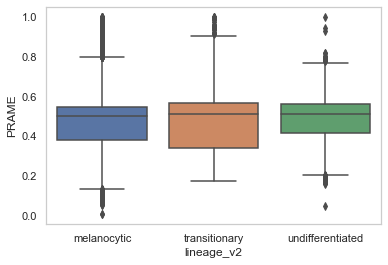

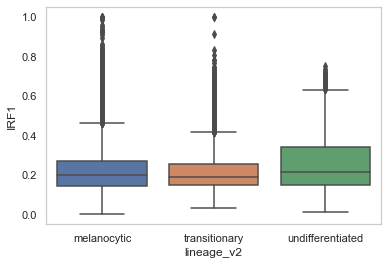

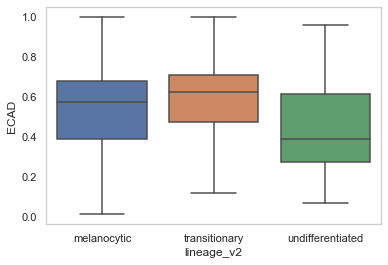

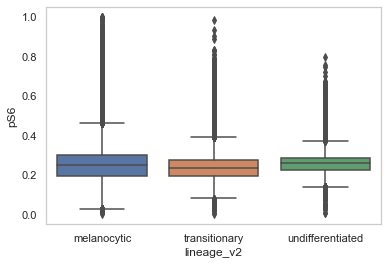

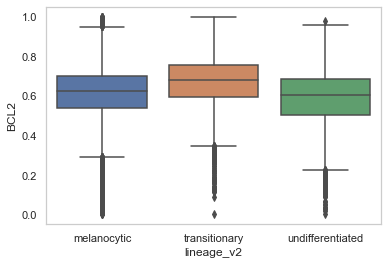

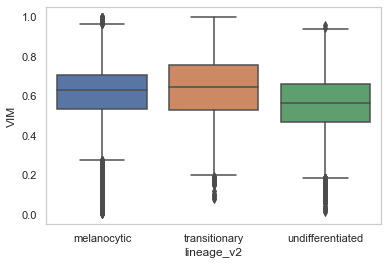

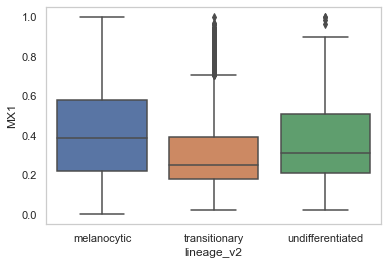

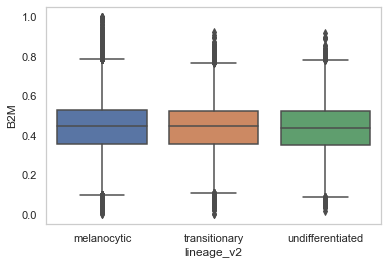

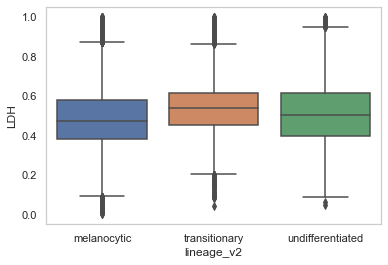

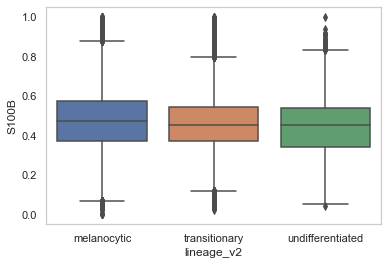

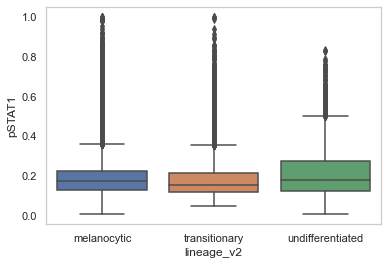

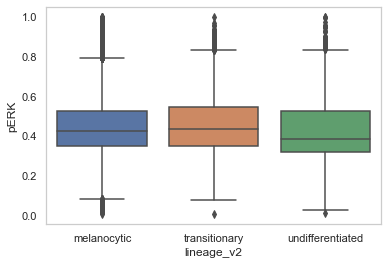

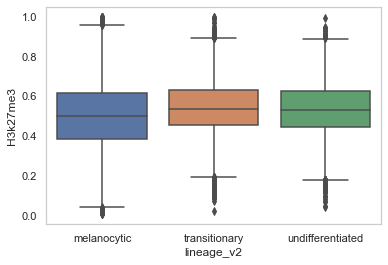

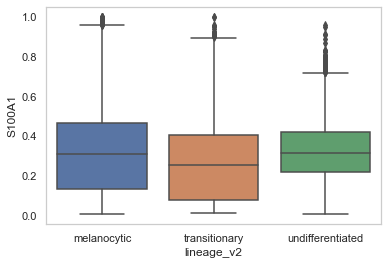

In [59]:
marker_list = ['PRAME', 'IRF1', 'ECAD', 'pS6', 'BCL2', 'VIM', 'MX1', 'B2M', 'LDH', 'S100B', 'pSTAT1', 'pERK', 'H3k27me3', 'S100A1']
for marker in marker_list:
    plt.figure()
    sns.boxplot(y=df[marker], x=df['lineage_v2'])

In [93]:
viz_hist = False

tumor_phenotype_combos = list(permutations(['melanocytic', 'transitionary', 'undifferentiated'], 2)) # note - order is important when performing one-sided stochastic dominance test
tumor_phenotype_marker_dict = {}
for combo in tumor_phenotype_combos:
    group1 = combo[0]
    group2 = combo[1]
    print(f'Perform MWU Hypothesis Testing on: {group1}, {group2}')
    marker_df_group1 = df[df['lineage_v2'] == group1]
    marker_df_group2 = df[df['lineage_v2'] == group2]

    combo_marker_dict = {}
    for marker in marker_list:
        if viz_hist == True:
            # visualize distributions
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.suptitle(f'Histogram of {marker}')
            ax1.hist(marker_df_group1[marker], bins=20, histtype='bar', ec='k') 
            ax2.hist(marker_df_group2[marker], bins=20, histtype='bar', ec='k') 
            ax1.set_xlabel(group1)
            ax2.set_xlabel(group2)
            fig.tight_layout()
            plt.show()

        # test if group1, e.g. melanocytic stochastically dominates (greater than) group2, e.g. undifferentiated
        U, p_value = stats.mannwhitneyu(x=marker_df_group1[marker], y=marker_df_group2[marker], alternative = 'greater')
        combo_marker_dict[marker] = p_value #{'U': U, 'p_value': p_value}
    tumor_phenotype_marker_dict[f'{group1}_{group2}'] = combo_marker_dict
    

Perform MWU Hypothesis Testing on: melanocytic, transitionary
Perform MWU Hypothesis Testing on: melanocytic, undifferentiated
Perform MWU Hypothesis Testing on: transitionary, melanocytic
Perform MWU Hypothesis Testing on: transitionary, undifferentiated
Perform MWU Hypothesis Testing on: undifferentiated, melanocytic
Perform MWU Hypothesis Testing on: undifferentiated, transitionary


In [94]:
# Prints the nicely formatted dictionary
pprint.pprint(tumor_phenotype_marker_dict)

{'melanocytic_transitionary': {'B2M': 0.005119124961491246,
                               'BCL2': 1.0,
                               'ECAD': 1.0,
                               'H3k27me3': 1.0,
                               'IRF1': 1.1333127597403078e-05,
                               'LDH': 1.0,
                               'MX1': 0.0,
                               'PRAME': 1.0,
                               'S100A1': 0.0,
                               'S100B': 1.73132729688107e-49,
                               'VIM': 1.0,
                               'pERK': 1.0,
                               'pS6': 1.0991372426491489e-181,
                               'pSTAT1': 7.999240710649208e-200},
 'melanocytic_undifferentiated': {'B2M': 1.9897079546001837e-09,
                                  'BCL2': 3.0806201829488805e-74,
                                  'ECAD': 0.0,
                                  'H3k27me3': 1.0,
                                  'IRF1': 1.0,
          

In [100]:
tumor_phenotype_marker_df = pd.DataFrame(tumor_phenotype_marker_dict).T

<AxesSubplot:>

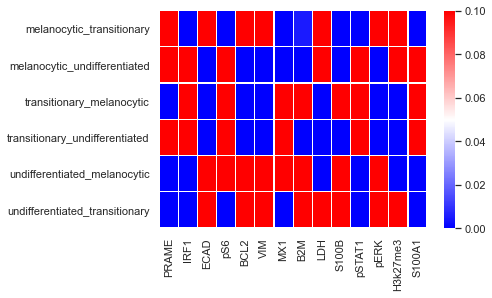

In [107]:
sns.heatmap(tumor_phenotype_marker_df, cmap='bwr', linewidths=0.2, vmin=0.0, vmax=0.1, center=0.05)

Text(0.5, 1.0, 'Group1 vs Group2 Stochastic Dominance Significant P Values')

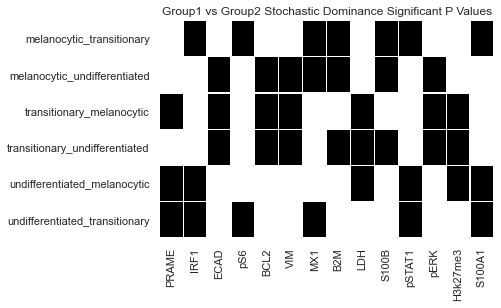

In [119]:
sns.heatmap(tumor_phenotype_marker_df < 0.05, cmap='binary', linewidths=0.2, cbar=False)
plt.title('Group1 vs Group2 Stochastic Dominance Significant P Values')

Perform MWU Hypothesis Testing on: melanocytic, undifferentiated
Perform MWU Hypothesis Testing on: transitionary, undifferentiated
Perform MWU Hypothesis Testing on: undifferentiated, melanocytic
Perform MWU Hypothesis Testing on: undifferentiated, transitionary


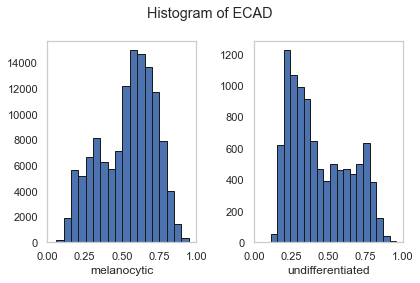

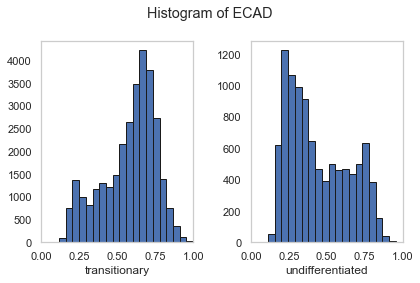

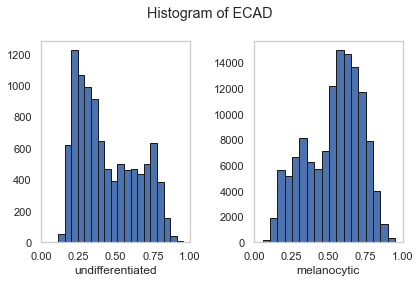

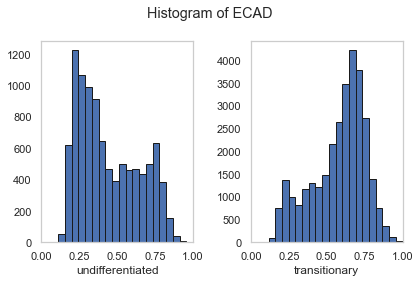

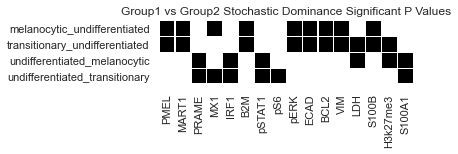

In [203]:
viz_hist = True

tumor_phenotype_combos = list(permutations(['melanocytic', 'transitionary', 'undifferentiated'], 2)) # note - order is important when performing one-sided stochastic dominance test
tumor_phenotype_marker_dict = {}
for combo in tumor_phenotype_combos:
    group1 = combo[0]
    group2 = combo[1]
    if group1 in ['undifferentiated'] or group2 in ['undifferentiated']:
        print(f'Perform MWU Hypothesis Testing on: {group1}, {group2}')
        marker_df_group1 = df[df['lineage_v2'] == group1]
        marker_df_group2 = df[df['lineage_v2'] == group2]

        combo_marker_dict = {}
        for marker in marker_list:
            if viz_hist == True:
                # visualize distributions
                if marker in ['ECAD','IRF1', 'pSTAT1', 'MX1', 'pS6', 'pERK']:
                    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
                    fig.suptitle(f'Histogram of {marker}')
                    ax1.hist(marker_df_group1[marker], bins=20, histtype='bar', ec='k') 
                    ax2.hist(marker_df_group2[marker], bins=20, histtype='bar', ec='k') 
                    ax1.set_xlabel(group1)
                    ax2.set_xlabel(group2)
                    ax1.set_xlim(0, 1)
                    ax2.set_xlim(0, 1)
                    fig.tight_layout()
                    plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/tumor_phenotype_comparison/{marker}_histograms_for_{group1}_vs_{group2}.pdf", format="pdf", bbox_inches="tight") 

            # test if group1, e.g. melanocytic stochastically dominates (greater than) group2, e.g. undifferentiated
            U, p_value = stats.mannwhitneyu(x=marker_df_group1[marker], y=marker_df_group2[marker], alternative = 'greater')
            combo_marker_dict[marker] = p_value #{'U': U, 'p_value': p_value}
        tumor_phenotype_marker_dict[f'{group1}_{group2}'] = combo_marker_dict

tumor_phenotype_marker_df = pd.DataFrame(tumor_phenotype_marker_dict).T
fig, ax = plt.subplots(1, 1)
sns.heatmap(tumor_phenotype_marker_df < 0.05, cmap='binary', linewidths=0.2, cbar=False, square=True)
plt.title('Group1 vs Group2 Stochastic Dominance Significant P Values')
fig.tight_layout()
plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/tumor_phenotype_comparison/stochastic_dominance_test_across_pairwise_groups.pdf", format="pdf", bbox_inches="tight")

In [172]:
# Identify samples of high marker expression in melanocytic and undifferentiated tumor cells
high_expr_samples = {}
for phenotype in ['melanocytic', 'undifferentiated']:
    for marker in ['IRF1', 'pSTAT1', 'MX1', 'pS6', 'pERK']:
        df2 = df[df['lineage_v2'] == phenotype]
        df3 = df2.sort_values(by=marker, ascending=True)
        df3 = df3[-5:]
        high_expr_samples[f'{phenotype}_{marker}'] = df3['MEL_id'].unique().tolist()

In [173]:
high_expr_samples

{'melanocytic_IRF1': ['MEL59', 'MEL53', 'MEL54', 'MEL19', 'MEL21'],
 'melanocytic_pSTAT1': ['MEL18', 'MEL31', 'MEL53', 'MEL60'],
 'melanocytic_MX1': ['MEL44', 'MEL39', 'MEL31', 'MEL14', 'MEL54'],
 'melanocytic_pS6': ['MEL19', 'MEL69', 'MEL31', 'MEL14'],
 'melanocytic_pERK': ['MEL50', 'MEL51', 'MEL68_B1', 'MEL60', 'MEL39'],
 'undifferentiated_IRF1': ['MEL44', 'MEL69'],
 'undifferentiated_pSTAT1': ['MEL68_B1', 'MEL55', 'MEL19', 'MEL25', 'MEL44'],
 'undifferentiated_MX1': ['MEL26', 'MEL40', 'MEL51'],
 'undifferentiated_pS6': ['MEL69', 'MEL14', 'MEL21'],
 'undifferentiated_pERK': ['MEL25', 'MEL69']}

In [121]:
# do MWU for e41 b2m, ecad splits
df.columns

Index(['PRAME', 'IRF1', 'ECAD', 'pS6', 'BCL2', 'VIM', 'MX1', 'B2M', 'LDH',
       'S100B', 'pSTAT1', 'pERK', 'H3k27me3', 'S100A1', 'X_centroid',
       'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength',
       'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID',
       'imageid', 'ROI', 'ROI_major_category', 'phenotype', 'MEL_id', 'B2Mpos',
       'KI67pos', 'optMPIscore', 'prolif', 'MART1pos', 'PMELpos', 'SOX9pos',
       'lineage', 'lineage_v2', 'prolif lineage', 'prolif_lineage_v2',
       'Ki67pos', 'PCNApos', 'Ki67_PCNApos', 'ECAD_pos', 'invasion', 'MX1pos',
       'IRF1pos', 'pSTAT1pos', 'IFN_signaling', 'example', 'leiden_v2',
       'leiden_0.7', 'leiden_0.5', 'leiden_0.4', 'BCL2pos', 'ECADpos'],
      dtype='object')

In [183]:
# hypothesis test within each tumor cell phenotype on subet_marker split
def stochastic_dominance_test(df, marker_list, tumor_phenotype_list=['melanocytic', 'transitionary', 'undifferentiated'], subset_marker='BCL2pos', viz_hist=False):
    for phenotype in tumor_phenotype_list:
        print(f'Processing: {phenotype}')
        phenotype_df = df[df['lineage_v2'] == phenotype]
        phenotype_subset_list = phenotype_df[subset_marker].unique().tolist()
        phenotype_subset_combos = list(permutations(phenotype_subset_list, 2)) # note - order is important when performing one-sided stochastic dominance test
        phenotype_subset_marker_dict = {}
        for combo in phenotype_subset_combos:
            group1 = combo[0]
            group2 = combo[1]
            print(f'Perform MWU Hypothesis Testing on: {group1}, {group2}')
            marker_df_group1 = phenotype_df[phenotype_df[subset_marker] == group1]
            marker_df_group2 = phenotype_df[phenotype_df[subset_marker] == group2]

            combo_marker_dict = {}
            for marker in marker_list:
                if viz_hist == True:
                    # visualize distributions
                    fig, (ax1, ax2) = plt.subplots(1, 2)
                    fig.suptitle(f'Histogram of {marker}')
                    ax1.hist(marker_df_group1[marker], bins=20, histtype='bar', ec='k') 
                    ax2.hist(marker_df_group2[marker], bins=20, histtype='bar', ec='k') 
                    ax1.set_xlabel(group1)
                    ax2.set_xlabel(group2)
                    fig.tight_layout()
                    plt.show()

                # test if group1, e.g. melanocytic stochastically dominates (greater than) group2, e.g. undifferentiated
                U, p_value = stats.mannwhitneyu(x=marker_df_group1[marker], y=marker_df_group2[marker], alternative = 'greater')
                combo_marker_dict[marker] = p_value #{'U': U, 'p_value': p_value}
            phenotype_subset_marker_dict[f'{group1}_{group2}'] = combo_marker_dict

        # Prints the nicely formatted dictionary
        # pprint.pprint(phenotype_subset_marker_dict)

        tumor_phenotype_marker_df = pd.DataFrame(phenotype_subset_marker_dict).T
        fig, ax = plt.subplots(1, 1)
        sns.heatmap(tumor_phenotype_marker_df < 0.05, cmap='binary', linewidths=0.2, cbar=False, square=True)
        plt.title(f'Stochastic Dominance Significant P Values for {phenotype} cells split according to {subset_marker}')
        fig.tight_layout()
        plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/tumor_phenotype_comparison/stochastic_dominance_test_{phenotype}_across_{subset_marker}_substates.pdf", format="pdf", bbox_inches="tight")

Processing: melanocytic
Perform MWU Hypothesis Testing on: BCL2+, BCL2-
Perform MWU Hypothesis Testing on: BCL2-, BCL2+
Processing: transitionary
Perform MWU Hypothesis Testing on: BCL2+, BCL2-
Perform MWU Hypothesis Testing on: BCL2-, BCL2+
Processing: undifferentiated
Perform MWU Hypothesis Testing on: BCL2+, BCL2-
Perform MWU Hypothesis Testing on: BCL2-, BCL2+


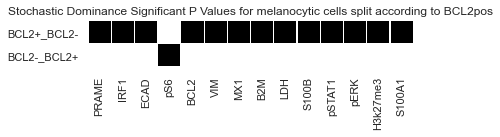

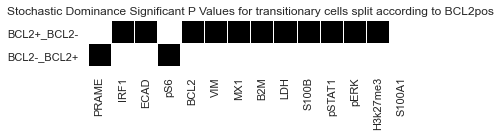

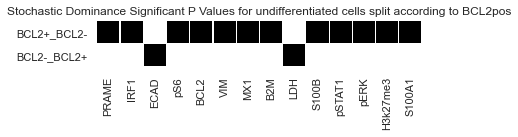

In [179]:
stochastic_dominance_test(df, marker_list=marker_list, subset_marker='BCL2pos', viz_hist=False)

Processing: melanocytic
Perform MWU Hypothesis Testing on: ECAD+, ECAD-
Perform MWU Hypothesis Testing on: ECAD-, ECAD+
Processing: transitionary
Perform MWU Hypothesis Testing on: ECAD+, ECAD-
Perform MWU Hypothesis Testing on: ECAD-, ECAD+
Processing: undifferentiated
Perform MWU Hypothesis Testing on: ECAD+, ECAD-
Perform MWU Hypothesis Testing on: ECAD-, ECAD+


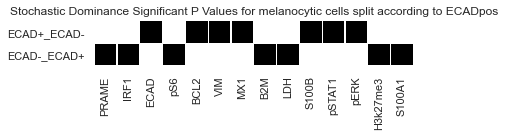

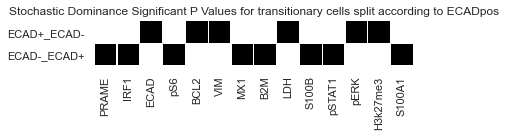

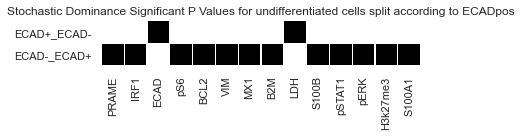

In [180]:
stochastic_dominance_test(df, marker_list=marker_list, subset_marker='ECADpos', viz_hist=False)

In [46]:
# write function to take only tumor_phenotype_subset='melanocytic' cells and the marker to split on, e.g. 'MART1' and 'PMEL'
# do for melanocytic and transitionary cells, each on 'MART1' and 'PMEL'
adata = scanpy.read_h5ad('/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/experiment_41_data/e41_tumor_11222023.h5ad')

In [47]:
print(adata)
X = adata.to_df()
meta_df = adata.obs
df = pd.merge(X, meta_df, left_index=True, right_index=True)


AnnData object with n_obs × n_vars = 168230 × 16
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'ROI', 'ROI_major_category', 'phenotype', 'MEL_id', 'B2Mpos', 'KI67pos', 'optMPIscore', 'prolif', 'MART1pos', 'PMELpos', 'SOX9pos', 'lineage', 'lineage_v2', 'prolif lineage', 'prolif_lineage_v2', 'Ki67pos', 'PCNApos', 'Ki67_PCNApos', 'ECAD_pos', 'invasion', 'MX1pos', 'IRF1pos', 'pSTAT1pos', 'IFN_signaling', 'example', 'BCL2pos', 'ECADpos'
    uns: 'all_markers', 'dendrogram_lineage_v2', 'dendrogram_prolif', 'gates', 'imageid_colors', 'spatial_distance'
    obsm: 'umap', 'umap_combat'
    layers: 'combat', 'rescaled'


In [56]:
marker_list = ['PMEL', 'MART1', 'PRAME', 'MX1', 'IRF1', 'B2M', 'pSTAT1', 'pS6', 'pERK', 'ECAD', 'BCL2', 'VIM', 'LDH', 'S100B', 'H3k27me3', 'S100A1']

Processing: melanocytic
Perform MWU Hypothesis Testing on: MART1-, MART1+
Perform MWU Hypothesis Testing on: MART1+, MART1-
Processing: transitionary
Perform MWU Hypothesis Testing on: MART1+, MART1-
Perform MWU Hypothesis Testing on: MART1-, MART1+


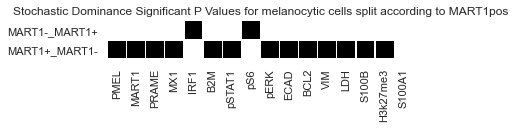

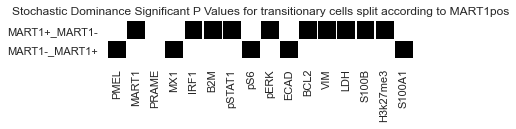

In [189]:
stochastic_dominance_test(df, marker_list=marker_list, tumor_phenotype_list=['melanocytic', 'transitionary'], subset_marker='MART1pos', viz_hist=False)

Processing: melanocytic
Perform MWU Hypothesis Testing on: PMEL-, PMEL+
Perform MWU Hypothesis Testing on: PMEL+, PMEL-
Processing: transitionary
Perform MWU Hypothesis Testing on: PMEL+, PMEL-
Perform MWU Hypothesis Testing on: PMEL-, PMEL+


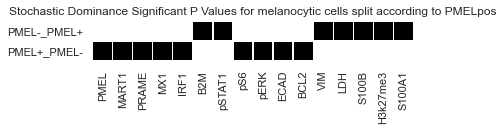

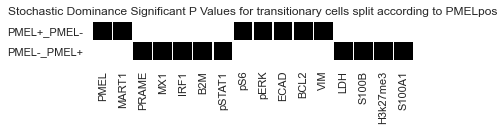

In [190]:
stochastic_dominance_test(df, marker_list=marker_list, tumor_phenotype_list=['melanocytic', 'transitionary'], subset_marker='PMELpos', viz_hist=False)

In [108]:
def phenotype_subset_marker_heatmap(df, marker_list, tumor_phenotype_list=['melanocytic', 'transitionary', 'undifferentiated'], subset_marker='ECADpos'):
    phenotype_subset_mean_dict = {}
    for phenotype in tumor_phenotype_list:
        phenotype_df = df[df['lineage_v2'] == phenotype]
        phenotype_subset_list = phenotype_df[subset_marker].unique().tolist() # e.g., ['ECAD+', 'ECAD-']
        for subset_split in phenotype_subset_list:
            phenotype_subset_df = phenotype_df[phenotype_df[subset_marker] == subset_split]
            phenotype_subset_df = phenotype_subset_df[marker_list]
            phenotype_subset_mean_dict[f'{phenotype}_{subset_split}'] = phenotype_subset_df.mean()
    phenotype_subset_mean_df = pd.DataFrame.from_dict(phenotype_subset_mean_dict)
    sns.clustermap(phenotype_subset_mean_df, col_cluster=True, row_cluster=False, cmap="vlag", vmin=0.1,vmax=0.7, annot=True, square=False, linewidths=0.01, linecolor='lightgray')
    plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/tumor_phenotype_comparison/phenotype_heatmap_by_{subset_marker}_splits.pdf", format="pdf", bbox_inches="tight")
    return phenotype_subset_mean_df

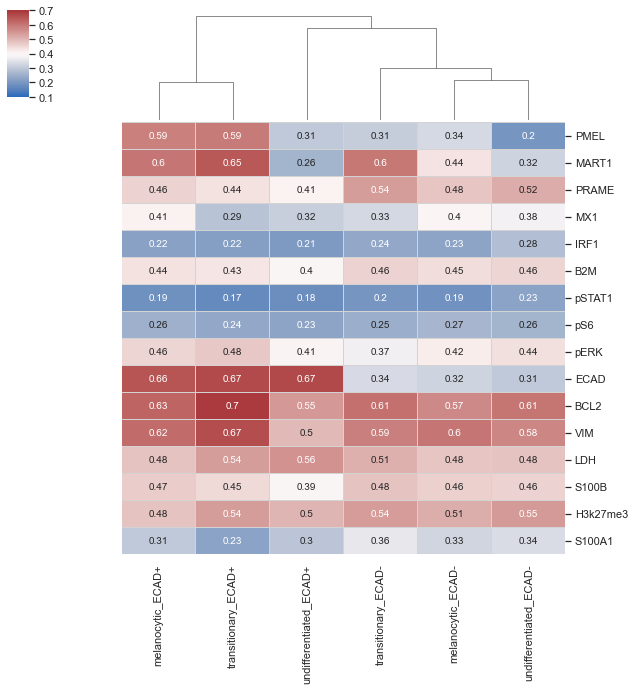

In [109]:
_ = phenotype_subset_marker_heatmap(df, marker_list, tumor_phenotype_list=['melanocytic', 'transitionary', 'undifferentiated'], subset_marker='ECADpos')

### Add text to Heatmap

In [2]:
tumor = scanpy.read_h5ad("/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/experiment_41_data/e41_tumor_12012023.h5ad")

/Users/ediknovik/anaconda3/envs/spatial/lib/python3.6/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


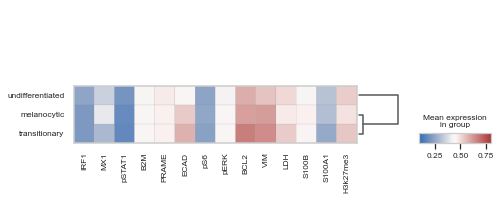

In [16]:
names=[ 'IRF1', 'MX1', 'pSTAT1','B2M','PRAME', 'ECAD', 'pS6','pERK', 'BCL2', 'VIM', 'LDH','S100B','S100A1','H3k27me3']
scanpy.tl.dendrogram(tumor, groupby='lineage_v2')
scanpy.pl.matrixplot(tumor, var_names=names, groupby='lineage_v2', layer='rescaled', dendrogram=True, use_raw=False, cmap="vlag", swap_axes = False, vmin=0.1,vmax=0.8, save=False)

In [36]:
mp.__dict__['values_df']
mp = scanpy.pl.matrixplot(tumor, var_names=names, groupby='lineage_v2', layer='rescaled', dendrogram=True, use_raw=False, cmap="vlag", swap_axes = False, vmin=0.1,vmax=0.8, save=False, return_fig=True)

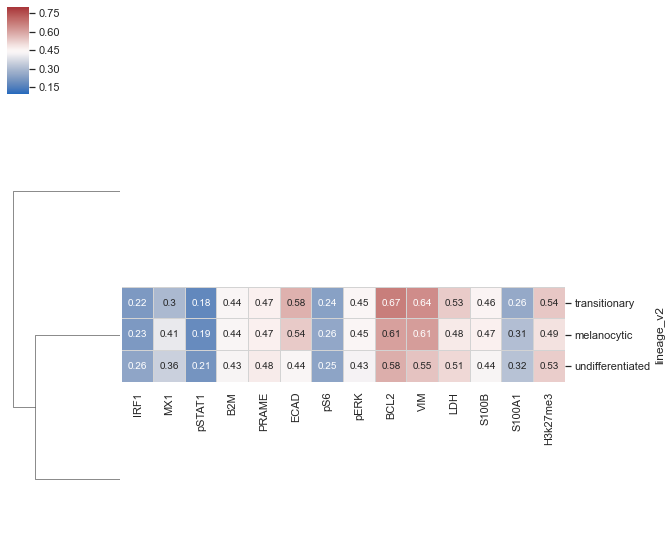

In [45]:
sns.clustermap(mp.__dict__['values_df'], col_cluster=False, row_cluster=True, cmap="vlag", vmin=0.1,vmax=0.8, annot=True, square=True, linewidths=0.01, linecolor='lightgray')
plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/grouped_tumor_phenotype_heatmap_with_numbers.pdf", format="pdf", bbox_inches="tight")
